In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, randint
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RepeatedKFold,
    cross_val_score,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# for mounting google colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Reading the data file
parquet_file = ('/content/gdrive/My Drive/ML/TM_data_withFeatures_OxidMatched_Uncommon_3')
df = pd.read_parquet(parquet_file, engine='auto')
print (df.shape)

(181054, 101)


In [4]:
# Selecting space groups with values higher than 500
counts = df['SG #'].value_counts()
x = df.loc[df['SG #'].isin(counts.index[counts > 500])]
x['SG #'].unique()

array([216, 227,  62, 166,  14, 139, 194, 221, 225, 187, 156])

In [5]:
x3 = df[~df['SG #'].isin(x['SG #'])]


In [6]:
col_to_replace = x3['SG #'].unique()

In [7]:
df['SG #'].unique()

array([216, 186, 227,  62, 123,  71,  11, 140, 193, 167,  10,  44, 128,
        12,  87,  29,  58, 141,  40,  82, 112,   1,  79,   2, 130,  55,
        63, 229, 138,  51, 124, 176, 136,   4,  15, 166,  14, 137,  56,
        74, 135,  88,  65,  52, 109, 164,  36,  31,  33, 139,  60, 157,
       162, 148, 185, 217, 146,  64, 127, 194, 223, 221,  19,  76, 122,
       225,   9,  59,  61,  45, 205, 226, 173,  68, 191, 187, 189,  13,
        35, 198, 129,  85,  26, 150, 206,  57, 156, 204, 188,   7,  84,
         8, 116, 132, 147, 163,  67, 152, 213,  53,  25, 107, 160, 131,
        38,   6,  86, 212, 190, 145, 182,  72,  91, 161, 121,  47,  70,
       215, 214,  43, 115,   5, 174,  96, 218, 105, 102, 183,  46,  50,
        83,  39, 200, 113,  80, 114, 126,  92, 142,  73,  23, 119,  81,
       111, 125,  66,  69,  95, 108,  18,  41, 220, 199, 120, 159, 181,
       165, 158, 133,  42, 180,  54,  97, 117,  34, 143, 230,  99,  20,
       154, 118, 155,  94, 110, 224, 134,  30,  37])

In [ ]:
['Pm-3m', 'R-3m', 'F-43m', 'P3m1', 'R3m', 'Fm-3m', 'I4/mmm', 'Pnma',
       'Fd-3m', 'R-3', 'P-6m2', 'P2_1/c', 'P6_3/mmc']

In [7]:
x_tmp = df

In [10]:
x_tmp[x_tmp['SG #'] == 555].count()

A Symbol           6819
Atomic Number 1    6819
Coefficient 1      6819
B Symbol           6819
Atomic Number 2    6819
                   ... 
C - Ioniz Pot      6819
gamma              6819
Oxidation 1        6819
Oxidation 2        6819
Oxidation 3        6819
Length: 101, dtype: int64

In [8]:

x_tmp['SG #'] = x_tmp['SG #'].replace( to_replace = col_to_replace, value = 555)

In [9]:
x_tmp['SG #'].unique()

array([216, 555, 227,  62, 166,  14, 139, 194, 221, 225, 187, 156])

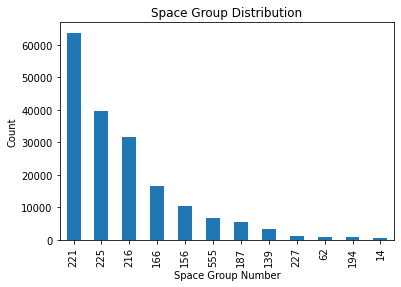

In [17]:
# Top 10 SG dist
sgc = x_tmp['SG #'].value_counts()
sgct = sgc.head(10)
sgc.plot(kind='bar', title='Space Group Distribution', ylabel='Count', xlabel='Space Group Number')

In [18]:
prop = 100*sgc/181054 

In [24]:
prop.to_frame()

,SG #
221,35.235344
225,21.927160
216,17.517978
166,9.127664
156,5.805450
555,3.766280
187,3.009047
139,1.826527
227,0.663338
62,0.464502


In [11]:
#x = df.loc[(df['SG #'].isin([221, 225, 216, 166, 156, 187, 139, 227, 62, 194, 14]))]
# Feature based on choice
x2 = x_tmp[['Coefficient 1', 'Coefficient 2', 'Coefficient 3', 'A IonicRadius', 'B IonicRadius', 'C IonicRadius', 
        'Oxidation 1', 'Oxidation 2', 'Oxidation 3', 'A IonizationPot1st', 'B IonizationPot1st', 'C IonizationPot1st']]
# initiaing the target
y = x_tmp['SG #']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    x2, y, train_size=0.7, shuffle=True, random_state=123)

In [16]:
x2.describe()

,Coefficient 1,Coefficient 2,Coefficient 3,A IonicRadius,B IonicRadius,C IonicRadius,Oxidation 1,Oxidation 2,Oxidation 3,A IonizationPot1st,B IonizationPot1st,C IonizationPot1st
count,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000,181054.000000
mean,1.589471,1.410883,1.803158,0.887039,0.828008,0.758978,2.161339,-0.028572,-1.751930,7.933087,7.816270,7.950483
std,1.044767,0.846623,1.261257,0.462845,0.400128,0.367898,1.347820,1.888336,1.026318,2.140027,2.128748,1.709012
min,1.000000,1.000000,1.000000,0.160000,0.160000,0.170000,1.000000,-5.000000,-5.000000,3.893900,3.893900,3.893900
25%,1.000000,1.000000,1.000000,0.580000,0.620000,0.590000,1.000000,-1.000000,-2.000000,6.113200,6.758900,6.828200
50%,1.000000,1.000000,1.000000,0.730000,0.690000,0.640000,2.000000,-1.000000,-1.000000,7.646200,7.639800,7.880000
75%,2.000000,1.000000,3.000000,1.150000,1.020000,0.840000,3.000000,1.000000,-1.000000,9.100000,8.700000,8.700000
max,19.000000,10.000000,33.000000,2.200000,2.200000,2.200000,7.000000,7.000000,-1.000000,14.534100,17.422800,17.422800


# Logistic Regression Classifier

## Default Model

In [16]:
# create Logisitc Model
log_model = LogisticRegression(
    max_iter=200,
    verbose=True,
)

result = log_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:812: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.0s finished


### Deployment

In [17]:
from sklearn.metrics import classification_report, make_scorer, accuracy_score

y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.00      0.00      0.00       145
          62       0.00      0.00      0.00       266
         139       0.00      0.00      0.00       969
         156       0.50      0.64      0.56      3275
         166       0.44      0.03      0.06      4902
         187       0.10      0.02      0.03      1672
         194       0.00      0.00      0.00       216
         216       0.65      0.50      0.57      9445
         221       0.77      0.91      0.83     19051
         225       0.61      0.96      0.75     11994
         227       0.58      0.12      0.20       365
         555       0.71      0.34      0.46      2017

    accuracy                           0.67     54317
   macro avg       0.36      0.29      0.29     54317
weighted avg       0.62      0.67      0.61     54317



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Tuning

In [19]:
# create Logisitc Model
log_cv = LogisticRegressionCV(
    cv=5,
    solver="saga",
    scoring="accuracy",
    n_jobs=10,
    verbose=True,
    max_iter=100,
)

# train
results = log_cv.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


max_iter reached after 84 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 88 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 111 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 112 seconds
max_iter reached after 112 seconds
max_iter reached after 112 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 110 seconds
max_iter reached after 110 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 111 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 108 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 106 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 110 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 109 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 109 seconds
max_iter reached after 110 seconds
max_iter reached after 109 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 111 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 109 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
max_iter reached after 110 seconds
max_iter reached after 111 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 110 seconds
convergence after 94 epochs took 101 seconds
max_iter reached after 107 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 95 seconds
max_iter reached after 96 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 95 seconds
max_iter reached after 96 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 95 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 78 seconds
max_iter reached after 80 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 80 seconds
max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 78 seconds
max_iter reached after 78 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 79 seconds
max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 78 seconds
max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 79 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


max_iter reached after 80 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,


convergence after 76 epochs took 60 seconds
convergence after 94 epochs took 71 seconds
max_iter reached after 75 seconds
max_iter reached after 72 seconds
max_iter reached after 73 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  verbose,
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 16.0min finished


In [20]:
test_accuracy = result.score(X_test, y_test)
train_accuracy = result.score(X_train, y_train)

In [22]:
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.00      0.00      0.00       145
          62       0.00      0.00      0.00       266
         139       0.00      0.00      0.00       969
         156       0.50      0.64      0.56      3275
         166       0.44      0.03      0.06      4902
         187       0.10      0.02      0.03      1672
         194       0.00      0.00      0.00       216
         216       0.65      0.50      0.57      9445
         221       0.77      0.91      0.83     19051
         225       0.61      0.96      0.75     11994
         227       0.58      0.12      0.20       365
         555       0.71      0.34      0.46      2017

    accuracy                           0.67     54317
   macro avg       0.36      0.29      0.29     54317
weighted avg       0.62      0.67      0.61     54317



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
test_accuracy
train_accuracy

0.6719900265904984

# KNN Classifier


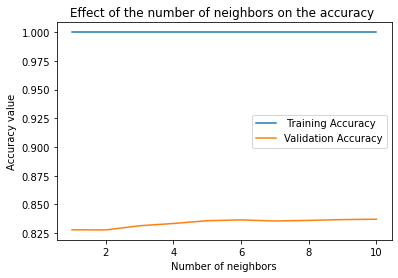

In [31]:
#KNN training

N = 10 #len(X_train)-1 ; # number of samples, we tried all possible k vlaues then we reduced it to 50 to choose a proper value of k
accuracy_training= [] #initializing an empty set to save the value of the training accuracy
accuracy_validation= [] #initializing an empty set to save the value of the validation accuracy
weights = "distance"; # using distance not uniform so the closer neighbors have higher influence than the far ones
metric = "euclidean"; # the distance metric to use
for i in range(N):
  kNN = KNeighborsClassifier(n_neighbors=i+1, weights = weights, metric = metric);  # kNN model
  kNN.fit(X_train, y_train) 
  #y_pred_val = kNN.predict(X_val) # prediction on test data
  #knn_val=cross_val_score(kNN,X_train,y_train.ravel(), cv=11)
  accuracy_training.append(kNN.score(X_train, y_train))
  accuracy_validation.append(kNN.score(X_test, y_test))

plt.plot(range(1, N+1), accuracy_training,range(1, N+1), accuracy_validation)
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy value")
plt.title("Effect of the number of neighbors on the accuracy ")
plt.legend([" Training Accuracy","Validation Accuracy"])
plt.show()

In [33]:
from sklearn.metrics import classification_report, make_scorer, accuracy_score

y_pred_train = kNN.predict(X_train)
y_pred_test = kNN.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.54      0.21      0.31       145
          62       0.58      0.24      0.34       266
         139       0.87      0.86      0.86       969
         156       0.66      0.77      0.71      3275
         166       0.53      0.45      0.49      4902
         187       0.53      0.46      0.49      1672
         194       0.66      0.36      0.47       216
         216       0.92      0.87      0.89      9445
         221       0.98      1.00      0.99     19051
         225       0.77      0.84      0.80     11994
         227       0.75      0.82      0.78       365
         555       0.79      0.68      0.73      2017

    accuracy                           0.84     54317
   macro avg       0.71      0.63      0.66     54317
weighted avg       0.83      0.84      0.83     54317



In [37]:
# %%
import joblib

joblib.dump(kNN, "/content/gdrive/My Drive/kNN10.pkl")

['/content/gdrive/My Drive/kNN10.pkl']

In [15]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,10))
n_neighbors = list(range(1,2))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
TkNN = KNeighborsClassifier()
#Use GridSearch
TkNNclf = GridSearchCV(TkNN, hyperparameters, cv=10)
#Fit the model
best_model = TkNNclf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 2
Best p: 1
Best n_neighbors: 1


In [25]:
from sklearn.metrics import classification_report, make_scorer, accuracy_score
weights = "distance"; # using distance not uniform so the closer neighbors have higher influence than the far ones
metric = "euclidean"; # the distance metric to use
TkNN = KNeighborsClassifier(n_neighbors = 1, leaf_size = 10, p=1, weights = weights, metric = metric)
TkNN.fit(X_train, y_train)

y_pred_train = TkNN.predict(X_train)
y_pred_test = TkNN.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.34      0.34      0.34       145
          62       0.48      0.39      0.43       266
         139       0.88      0.85      0.87       969
         156       0.68      0.69      0.69      3275
         166       0.48      0.51      0.50      4902
         187       0.49      0.50      0.49      1672
         194       0.52      0.48      0.50       216
         216       0.88      0.89      0.88      9445
         221       0.99      1.00      1.00     19051
         225       0.78      0.76      0.77     11994
         227       0.78      0.82      0.80       365
         555       0.76      0.72      0.74      2017

    accuracy                           0.83     54317
   macro avg       0.67      0.66      0.67     54317
weighted avg       0.83      0.83      0.83     54317



# Support Vector Machine Classifier (SVC)

In [31]:
from sklearn.svm import SVC

SVMC = SVC(max_iter = 1000, random_state=0)
result = SVMC.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [32]:
y_pred_train = SVMC.predict(X_train)
y_pred_test = SVMC.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.00      0.00      0.00       145
          62       0.00      0.00      0.00       266
         139       0.83      0.27      0.41       969
         156       0.45      0.06      0.10      3275
         166       0.36      0.02      0.03      4902
         187       0.28      0.92      0.43      1672
         194       0.00      0.00      0.00       216
         216       0.07      0.00      0.00      9445
         221       0.85      0.20      0.32     19051
         225       0.68      0.97      0.80     11994
         227       0.84      0.09      0.16       365
         555       0.07      0.86      0.12      2017

    accuracy                           0.35     54317
   macro avg       0.37      0.28      0.20     54317
weighted avg       0.55      0.35      0.32     54317



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# Decision Tree

In [34]:
from sklearn import tree

#Decision Tress model object
dtclf = tree.DecisionTreeClassifier()

In [35]:
#loss function

# 5 fold CV object
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

# create new feature set with encoded features

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

#Tune the model using grid search
grid_search = GridSearchCV(dtclf, hyper_grid, cv=kfold)
results = grid_search.fit(X_train, y_train)

# Optimal penalty parameter in grid search
print(results.best_estimator_.get_params())

# Best model's cross validated RMSE
print(round(abs(results.best_score_), 2))


{'ccp_alpha': 1e-05, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
0.86


In [36]:
dtclf = tree.DecisionTreeClassifier(ccp_alpha= 1e-5, max_depth= 15, min_samples_leaf = 1, min_samples_split= 2).fit(X_train, y_train)

In [37]:
y_pred_train = dtclf.predict(X_train)
y_pred_test = dtclf.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          14       0.47      0.41      0.44       145
          62       0.48      0.39      0.43       266
         139       0.89      0.90      0.90       969
         156       0.63      0.80      0.71      3275
         166       0.61      0.49      0.55      4902
         187       0.47      0.39      0.43      1672
         194       0.62      0.32      0.43       216
         216       0.96      0.88      0.91      9445
         221       1.00      1.00      1.00     19051
         225       0.79      0.88      0.83     11994
         227       0.83      0.90      0.86       365
         555       0.81      0.77      0.79      2017

    accuracy                           0.86     54317
   macro avg       0.71      0.68      0.69     54317
weighted avg       0.86      0.86      0.85     54317

